# Weight fee calculations

## Functionality

The main goal of this notebook is to get a `weight_coefficient` for the `WeightToFee` given a `price_to_demand` function and explore the price implications.

## How to use

Simply run everysingle cell and at the end you will have a dashboard to explore the prices and functions

To explore different demand functions you need to change it in its corresponding cell.

There are also some constants that need to be updated should the runtime change.

### Importing relevant modules

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
from math import ceil
from scipy import optimize
import pandas as pd
%matplotlib notebook

### Parsing weight files

This section parses the weight files in weights/ to have a dictionary with all possible extrinsic weight

The dictionary have the following format

```
{
    extrinsic_name: {
        "base_weight": base_weight,
        "db_reads": {
            "base": base_weight,
            "vars": [db_vars]
        },
        "db_writes": {
            "base": base_weight,
            "vars": [db_vars]
        },
        "vars": vars
    }
}
```

**Note:** the parsing is very specific for the generated weight files, this is very brittle. A future upgrade could be to use some kind of rust parser. 

In [2]:
import re
from os import listdir

import pathlib
WEIGHTS_DIR = pathlib.Path().absolute().parent / 'runtime' / 'src' / 'weights'

BASE_WEIGHT = "base_weight"
DB_READS = "db_reads"
DB_WRITES = "db_writes"
BASE_DB = "base"
DB_VARS = "vars"
TRANSFER = "pallet_balances::transfer"
RUNTIME_UPGRADE = "pallet_codex::runtime_upgrade"
VARS = "vars"

match_parenthesis = r'\(.*'
match_base_weight = r'\(((\d+_{0,1})+)'
re_match_base_weight = re.compile(match_base_weight)
match_db_ops_reads = r'DbWeight::get\(\).reads\((\d+) as Weight\)'
match_db_ops_writes = r'DbWeight::get\(\).writes\((\d+) as Weight\)'
re_match_db_ops_reads = re.compile(match_db_ops_reads)
re_match_db_ops_writes = re.compile(match_db_ops_writes)
match_scaling_var = r'\((\D) as Weight\)'
re_match_scaling_var = re.compile(match_scaling_var)

weights = {}
for file_name in listdir(WEIGHTS_DIR):
    with open(WEIGHTS_DIR / file_name) as f:
        start_reading = False
        reading_func = False
        function_name = ""
        weight = 0
        db_reads_base = 0
        db_reads = []
        db_writes_base = 0
        db_writes = []
        variables = []
        pallet_name = ""
        for line in f:
            words = line.strip().split(" ")
            if words[0] == "impl":
                start_reading = True
                pallet_name = words[1].split("::")[0]

            if reading_func:
                if reading_func and "}" in words:
                    reading_func = False
                    weights[function_name] = {
                        BASE_WEIGHT: weight,
                        DB_READS: {
                            BASE_DB: db_reads_base,
                            DB_VARS: db_reads
                        },
                        DB_WRITES: {
                            BASE_DB: db_writes_base,
                            DB_VARS: db_writes,
                        },
                        VARS: variables
                    }
                    weight = 0
                    db_reads_base = 0
                    db_writes_base = 0
                    variables = []
                    db_reads = []
                    db_writes = []

                if "DbWeight::get()" in line:
                    if "reads" in line:
                        if re.search(re_match_scaling_var, line):
                            var = re.search(
                                re_match_scaling_var, line).group(1)
                            weight_factor = re.search(
                                re_match_base_weight, line).group(1)
                            db_reads.append((var, int(weight_factor)))
                        else:
                            db_reads_base = int(
                                re.search(re_match_db_ops_reads, line).group(1))

                    if "writes" in line:
                        if re.search(re_match_scaling_var, line):
                            var = re.search(
                                re_match_scaling_var, line).group(1)
                            weight_factor = re.search(
                                re_match_base_weight, line).group(1)
                            db_writes.append((var, int(weight_factor)))
                        else:
                            db_writes_base = int(
                                re.search(re_match_db_ops_writes, line).group(1))
                else:
                    if re.match(re_match_base_weight, words[0]) is not None:
                        match = re.match(re_match_base_weight, words[0])
                        weight = int(match.group(1))

                    if re.search(re_match_scaling_var, line):
                        var = re.search(re_match_scaling_var, line).group(1)
                        weight_factor = re.search(
                            re_match_base_weight, line).group(1)
                        variables.append((var, int(weight_factor)))

            if start_reading and words[0] == "fn":
                reading_func = True
                function_name = re.sub(match_parenthesis, '', words[1])
                function_name = pallet_name + "::" + function_name

#### Additional weight dictionary configuration

In [13]:
MAX_BLOCK_WEIGHT = 2 * 1_000_000_000_000


weights[RUNTIME_UPGRADE] =  {
    BASE_WEIGHT: MAX_BLOCK_WEIGHT,
    DB_READS: {
        BASE_DB: 0,
        DB_VARS: []
    },
    DB_WRITES: {
        BASE_DB: 0,
        DB_VARS: []
    },
    VARS: []
}

# Length is a dictionary with the lengths for the functions
# if the length for a given extrinsic is not given 0 will be assumed
lengths = {
    RUNTIME_UPGRADE: 3_000_000
}

# This is an array of extrinsics to display if it is empty all extrinsics are displayed
display_extrinsics = [
    "pallet_balances::transfer", 
    RUNTIME_UPGRADE, 
    "working_group::add_worker", 
    "referendum::vote", 
    "proposals_discussion::add_post"
]

# A dictionary with avg. parameters for a given extrinsic if it's not given assumes 0
# Note: if any param is provided all params must be provided
params_avg = {
    "proposals_discussion::add_post": {
        'i': 3_000,
    }
}

### Constants & Defaults

In [4]:
# Weight of DB operations
WRITE_WEIGHT = 100 * 1_000_000
READ_WEIGHT = 25 * 1_000_000

# Maximum values 
ISSUANCE = 250_000_000
MARKET_CAP = 50 * 100 * 250 # cents

# Constants for our runtime
MAX_BLOCK_LENGTH = 5 * 1024 * 1024
MIN_EXTRINSIC_WEIGHT = 125 * 1_000_000

# Coefficient for the price/demand function. More about it in the function definition cell
DEMAND_COEFFICIENT = 0.1

# The targeted saturation for a block in the demand/price function
TARGET_SATURATION = 0.25

# Extrinsic used to adjust the price/demand function
DEFAULT_TARGET_EXTRINSIC = TRANSFER

### Mapping functions

In [5]:
# Assume that weight to fee is proportional
def weight_to_fee(weight, coeff):
    return coeff * weight

def length_to_fee(length, coeff):
    return coeff * length

def token_to_price(token, market_cap, issuance):
    return (market_cap / issuance) * token

def price_weight_function(x, weight_coefficient, market_cap, issuance): 
    return token_to_price(weight_to_fee(x, weight_coefficient), market_cap, issuance)

def price_length_function(x, length_coefficient, market_cap, issuance):
    return token_to_price(length_to_fee(x, length_coefficient), market_cap, issuance)

### Calculations

In [6]:
def invert_demand(target, demand_coefficient, market_cap):
    def targeted_demand_function(price):
        return target - demand_function(price, demand_coefficient, market_cap)
    
    sol = optimize.root_scalar(targeted_demand_function, bracket = [0, market_cap])
    return sol.root

def calculate_weight_coeff(demand_coefficient, market_cap, issuance, target_extrinsic_weight, length=0, length_coeff=0):
    ideal_price = invert_demand(TARGET_SATURATION, demand_coefficient, market_cap)
    token_to_price = market_cap / issuance
    ideal_tokens = ideal_price / token_to_price
    ideal_weight_tokens = ideal_tokens - (length_to_fee(length, length_coeff))
    coefficient = ideal_weight_tokens / target_extrinsic_weight
    return max(coefficient, 0)

def print_var_err(var, extrn):
    print("WARNING: the parameter {} isn't defined in the calculation for extrinsic: {}".format(var[0], extrn))
    
def calc_vars_weight(weight, extrinsic):
    total = 0
    if extrinsic in params_avg:
        for var in weight[VARS]:
            if var[0] in params_avg[extrinsic]:
                total += params_avg[extrinsic][var[0]] * var[1]
            else:
                print_var_err(var, extrinsic)
        for var in weight[DB_READS][DB_VARS]:
            if var[0] in params_avg[extrinsic]:
                total += params_avg[extrinsic][var[0]] * var[1] * READ_WEIGHT
            else:
                print_var_err(var, extrinsic)
        for var in weight[DB_WRITES][DB_VARS]:
            if var[0] in params_avg[extrinsic]:
                total += params_avg[extrinsic][var] * WRITE_WEIGHT
            else:
                print_var_err(var, extrinsic)
    return total

def calc_weight(weight, extrinsic):
    vars_weight = calc_vars_weight(weight, extrinsic)
    return vars_weight + \
        weight[BASE_WEIGHT] + \
        weight[DB_READS][BASE_DB] * READ_WEIGHT + \
        weight[DB_WRITES][BASE_DB] * WRITE_WEIGHT 

def calc_total_price(extrinsic, weight_coeff, market_cap, issuance, use_length=False, length_coeff=0):
        return price_weight_function(calc_weight(weights[extrinsic], extrinsic), weight_coeff, market_cap, issuance) + \
            price_length_function(lengths.get(extrinsic, 0), length_coeff, market_cap, issuance)

### Plotting functions

In [7]:
def plot_price_to_demand(demand_coeff, market_cap, issuance, target_extrinsic_weight, fig, ax, length=0, length_coeff=0):
    [l.remove() for l in ax.lines]
    
    x = np.linspace(0, MAX_BLOCK_WEIGHT, num=1000)
    
    ax.plot(x, demand_function(x, demand_coeff, market_cap), color='C0')
    weight_coeff = calculate_weight_coeff(demand_coeff, market_cap, issuance, target_extrinsic_weight, length, length_coeff)
    ideal_price = invert_demand(0.25, demand_coeff, market_cap)

    ax.axvline(ideal_price, color = 'r', linestyle='--')
    ax.axhline(0.25, color = 'r', linestyle='--')
    ax.set_xlim([0, market_cap * demand_coeff])
    
    return weight_coeff

def plot_weight_to_price(weight_coefficient, market_cap, issuance, fig, ax):
    [l.remove() for l in ax.lines]
    [l.remove() for l in ax.texts]

    x = np.linspace(0, MAX_BLOCK_WEIGHT, num=1000)

    ax.plot(x, price_weight_function(x, weight_coefficient, market_cap, issuance))
    ax.axhline(market_cap, color = 'r', linestyle='--')
    ax.axvline(MAX_BLOCK_WEIGHT, color = 'g', linestyle='--')
    ax.annotate("Market Cap", xy=(0, market_cap))
    ax.annotate("Maximum Block Weight", xy=(MAX_BLOCK_WEIGHT, price_weight_function(MAX_BLOCK_WEIGHT, weight_coefficient, market_cap, issuance)), horizontalalignment='right')
    ax.set_title("Weight to Price")
    ax.set_ylim([0, max(market_cap * 1.4, 1.4 * price_weight_function(MAX_BLOCK_WEIGHT, weight_coefficient, market_cap, issuance))])

### Widgets

In [8]:
demand_coeff_widget = BoundedFloatText(
    value=0.0001,
    min=0.0001,
    max=1,
    step=0.0001,
    description='Demand coefficient',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

market_cap_widget = BoundedIntText(
    value=MARKET_CAP / 1000 + 1,
    min=1,
    max=MARKET_CAP,
    step=MARKET_CAP / 1000,
    description='Market Cap(¢)',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

issuance_widget = BoundedIntText(
    value=ISSUANCE / 1000 + 1,
    min=1,
    max=ISSUANCE,
    step=ISSUANCE / 1000,
    description='Issuance',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

length_coefficient_widget = BoundedIntText(
    value=1,
    min=0,
    max=1_000_000,
    step=1,
    description='Length coefficient',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

target_extrinsic_widget = Dropdown(
    options=weights.keys(),
    value=DEFAULT_TARGET_EXTRINSIC,
    description='Target extrinsic',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

use_length_widget = Checkbox(
    value=False,
    description='Use length fee for coefficient calculation',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

watch_extrinsic_widget = Dropdown(
    options=weights.keys(),
    value=TRANSFER,
    description='Watching extrinsic',
    disabled=False,
    layout=Layout(width='auto', max_width='500px')
)

# Main functionality

## Demand function

A demand function maps a price to a demand, the demand is a number from 0 - 1 representing the block ocupation

Ideally a block should be %25 filled. And the algorithm finds the optimal price value for the given price-demand function to fullfill that condition.

The default function assumes that a `target_extrinsic` has a given `price` there is a linearly decreasing function that maps to the demand of a block. It makes the following extra assumptions:
* Any extrinsic with price 0 means that the blocks will be fully saturated always
* The incentive to saturate a block is inversly proportional on how much of the market cap an extrinsic costs

Parameters:
* `price` - the price of the extrinsic
* `demand_coefficient` - the proportion of the `market_cap` the extrinsic would cost such that using the extrinsic in any capacity would stop making sense
* `market_cap` - the market cap

**Note:** If the parameters for the function doesn't change and we can be sure the ideal price for that demand function is in [0, market_cap) it can be changed without any change. If the parameters change, very little changes have to be made to the script. However, if the second assumption change, the minimization algorithm needs to be changed.

In [9]:
# Demand is a proportion of block saturation
def demand_function(price, demand_coefficient, market_cap):
    return 1 - price / (market_cap * demand_coefficient)

## Dashboard

<IPython.core.display.Javascript object>


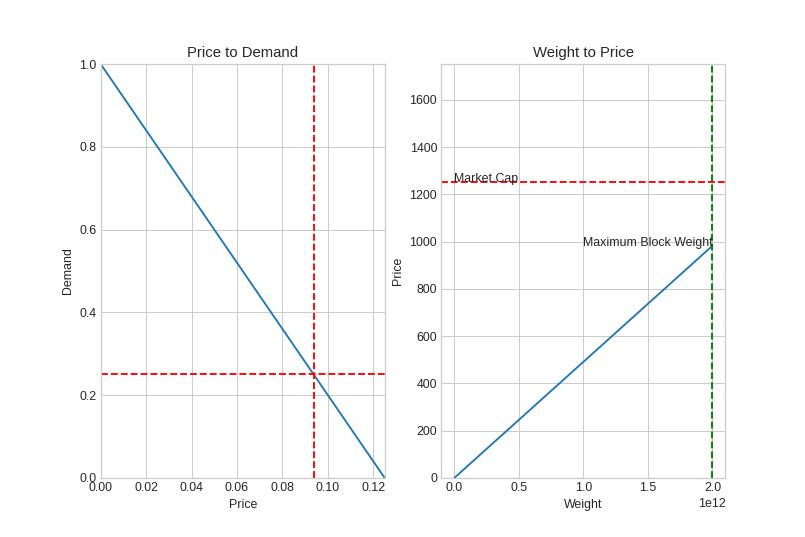

In [12]:
# Plots setup
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(9, 6))

weight_price_ax = ax[1]
price_demand_ax = ax[0]

price_demand_ax.set_title("Price to Demand")
price_demand_ax.set_xlabel("Price")
price_demand_ax.set_ylabel("Demand")
price_demand_ax.set_ylim([0, 1])

weight_price_ax.set_title("Weight to Price")
weight_price_ax.set_xlabel("Weight")
weight_price_ax.set_ylabel("Price")

# Main function

def update(
    demand_coeff, 
    market_cap, 
    issuance, 
    target_extrinsic, 
    length_coeff,
    use_length,
    watch_extrinsic
):
    target_extrinsic_weight = calc_weight(weights[target_extrinsic], target_extrinsic)
    target_extrinsic_length = lengths.get(target_extrinsic, 0)

    weight_coeff = plot_price_to_demand(
        demand_coeff, 
        market_cap, 
        issuance, 
        target_extrinsic_weight, 
        fig, 
        price_demand_ax, 
        target_extrinsic_length if use_length else 0, 
        length_coeff if use_length else 0
    )
    
    plot_weight_to_price(weight_coeff, market_cap, issuance, fig, weight_price_ax)

    watch_extrinsic_weight = calc_weight(weights[watch_extrinsic], watch_extrinsic)
    
    # Prints
    print("Weight coefficient: ", weight_coeff)
    
    print(target_extrinsic, " weight: ", target_extrinsic_weight)
    
    print(
        target_extrinsic, 
        " price: ",
        calc_total_price(target_extrinsic, weight_coeff, market_cap, issuance, use_length, length_coeff),
        "US$"
    )
    
    print(
        watch_extrinsic,
        " price: ",
        calc_total_price(watch_extrinsic, weight_coeff, market_cap, issuance, use_length, length_coeff),
        "US$"
    )
    
    # Display weights for all extrinsics
    names = []
    computed_weights = []
    prices = []
    for (key, val) in weights.items():
        if key in display_extrinsics:
            names.append(key)
            weight = calc_weight(val, key)
            computed_weights.append(weight)
            price = calc_total_price(key, weight_coeff, market_cap, issuance, True, length_coeff)
            prices.append(price / 100) # / 100 because we convert back to dollars
    
    weight_table = {"Extrinsic": names, "Weight": computed_weights, "Price(US$)": prices}
    df = pd.DataFrame(weight_table)
    
    display(df.style.hide_index())

# Widgets layout
    
w = interactive(
    update, 
    demand_coeff=demand_coeff_widget, 
    market_cap=market_cap_widget, 
    issuance=issuance_widget, 
    target_extrinsic=target_extrinsic_widget, 
    length_coeff=length_coefficient_widget,
    use_length=use_length_widget,
    watch_extrinsic=watch_extrinsic_widget
)

w.update()

VBox([HBox([c for c in w.children[0:3]]),HBox([c for c in w.children[3:5]]), w.children[5], w.children[6], w.children[-1]])